# Using a predefined random seed and saving the outputs at each step. This is for reproducibility. Simulation without noise

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import dataclasses as dt

In [3]:
import os
import shutil
from datetime import datetime
from pathlib import Path

import aps
import aps.ai.autoalignment.beamline34IDC.optimization.analysis_plot_utils as apu
import aps.ai.autoalignment.beamline34IDC.optimization.analysis_utils as analysis
import aps.ai.autoalignment.beamline34IDC.optimization.common as opt_common
import aps.ai.autoalignment.beamline34IDC.optimization.configs as configs
import aps.ai.autoalignment.beamline34IDC.optimization.movers as movers
import cmasher as cmm
import colorcet as cc
import joblib
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import optuna
from aps.ai.autoalignment.beamline34IDC.facade.focusing_optics_factory import (
    ExecutionMode,
    focusing_optics_factory_method,
)
from aps.ai.autoalignment.beamline34IDC.optimization.optuna_botorch import OptunaOptimizer
from aps.ai.autoalignment.beamline34IDC.simulation.facade.focusing_optics_interface import (
#    Layout,
    get_default_input_features,
)
from aps.ai.autoalignment.common.simulation.facade.parameters import Implementors
from aps.ai.autoalignment.common.util import clean_up
from aps.ai.autoalignment.common.util.common import AspectRatio, ColorMap, PlotMode
from aps.ai.autoalignment.common.util.shadow.common import (
    EmptyBeamException,
    HybridFailureException,
    PreProcessorFiles,
    load_shadow_beam,
)
from aps.ai.autoalignment.common.util.wrappers import load_beam
from epics import ca
from matplotlib import gridspec

ca.finalize_libca()

%matplotlib inline

**** The executable "caRepeater" couldn't be located
**** because of errno = "No such file or directory".
**** You may need to modify your PATH environment variable.
**** Unable to start "CA Repeater" process.


In [4]:
mpl.rcParams.update({"font.size": 12, "text.usetex": False, "svg.fonttype": "none"})

In [5]:
cur_dir = Path.cwd().resolve()
save_dir = cur_dir / "nf_fwhm_pl_one_step"
save_dir.mkdir(exist_ok=True)

### This is the analysis part

In [6]:
trials_file = save_dir / "trials.joblib"

In [7]:
hist_dir = Path(save_dir)
hist_dir.exists()

True

In [8]:
base_out_dir = Path("/Users/skandel/Library/CloudStorage/Box-Box/autofocus_paper/figures/34idc_sim_peak_fwhm_nlpi")
base_out_dir.mkdir(exist_ok=True)

In [74]:
out_dir = base_out_dir / "noise_free_onestep"
out_dir.mkdir(exist_ok=True)

In [75]:
ground_file =  "nf_fwhm_pl_pi/focused_beam.joblib"
ground_data = joblib.load(ground_file)

In [76]:
ground_dw = ground_data["dw"]
ground_hist = ground_data["hist"]

In [77]:
ground = {
    "FWHM": opt_common._get_fwhm_from_dw(ground_dw),
    "PL": opt_common._get_peak_distance_from_dw(ground_dw),
}
ground

{'FWHM': 0.0007627196949128243, 'PL': 0.00027836314089334333}

In [132]:
study = analysis.create_study_from_trials(trials_file, n_objectives=2)
n_steps = len(study.trials)
n_steps

[I 2023-08-10 12:35:55,863] A new study created in memory with name: no-name-108cf22b-fd51-448c-831f-646769c50e31


Assuming minimization for all objectives.


150

In [133]:
hists = analysis.load_histograms_from_files(n_steps, hist_dir, extension="gz")

In [134]:
maxcount = np.max(ground_hist.data_2D)
maxcount2 = np.max([h.data_2D for h in hists])

In [135]:
maxcount = np.maximum(maxcount, maxcount2)

In [136]:
m2 = apu.CMAP

Dictionary:
{'h_sigma': 0.000913103199300112, 'h_fwhm': 0.0004882812500000416, 'h_centroid': -6.4473340157794e-05, 'h_peak': -0.00017089843749999896, 'v_sigma': 0.0007594870538257947, 'v_fwhm': 0.00058593750000005, 'v_centroid': -0.0003280625367646186, 'v_peak': 0.00021972656249999965, 'integral_intensity': 8337.708788171103, 'peak_intensity': 43.56202587369089, 'gaussian_fit': {}}


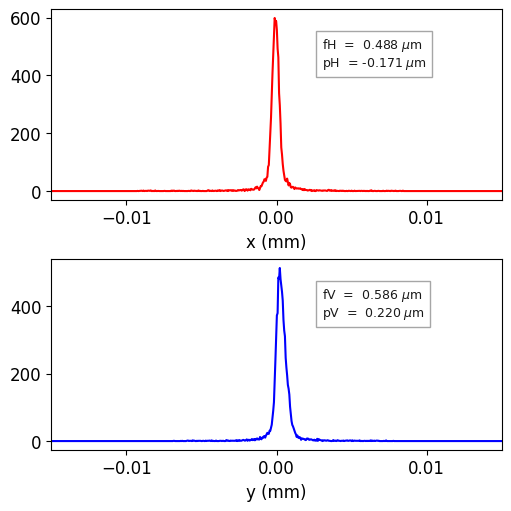

In [137]:

print('Dictionary:')
dwd = dict(ground_dw._DictionaryWrapper__dictionary)
print(dwd)

hist = ground_hist
xdata = hist.data_2D.sum(axis=1)
ydata = hist.data_2D.sum(axis=0)

fig, axs = plt.subplots(2, 1, figsize=[5, 5], constrained_layout=True)
axs[0].plot(hist.hh, xdata, color='red')
axs[0].set_xlim(-0.015, 0.015)
axs[0].set_xlabel(r'x (mm)')
axs[0].locator_params(nbins=4)


axs[1].plot(hist.vv[::-1], ydata, color='blue')
axs[1].set_xlim(-0.015, 0.015)
axs[1].set_xlabel(r'y (mm)')

axs[1].locator_params(nbins=4)



text1 = (
    rf"{'fH':<3} = {dwd['h_fwhm'] * 1000: 4.3f} $\mu$m" + "\n"
    rf"{'pH':<3} = {dwd['h_peak']* 1000: 4.3f} $\mu$m"
)
axs[0].text(
    0.6,
    0.7,
    text1,
    color="black",
    alpha=0.9,
    fontsize=9,
    bbox=dict(facecolor="white", edgecolor="gray", alpha=0.7),
    transform=axs[0].transAxes,
)

text2 = (
    rf"{'fV':<3} = {dwd['v_fwhm']* 1000: 4.3f} $\mu$m" + "\n"
    rf"{'pV':<3} = {dwd['v_peak']* 1000: 4.3f} $\mu$m"
    
)

axs[1].text(
    0.6,
    0.7,
    text2,
    color="black",
    alpha=0.9,
    fontsize=9,
    bbox=dict(facecolor="white", edgecolor="gray", alpha=0.7),
    transform=axs[1].transAxes,
)
#plt.savefig(f"{out_dir}/focussed.svg", bbox_inches="tight", dpi=600)
#plt.savefig(f"{out_dir}/focussed.png", bbox_inches="tight", dpi=600)
plt.show()

Trial number 0
Trial values: peak_distance 7.180e-03 fwhm 9.481e-04
Trial dw:
{'h_sigma': 0.0009818389597241156, 'h_fwhm': 0.0005371093750000458, 'h_centroid': 0.006857810671996284, 'h_peak': 0.006811523437500001, 'v_sigma': 0.0008704536161377667, 'v_fwhm': 0.0007812500000000666, 'v_centroid': -0.0025765108126593814, 'v_peak': 0.002270507812500001, 'integral_intensity': 8332.1491867267, 'peak_intensity': 33.91207860211913, 'gaussian_fit': {}}
Params:
{'hb_trans': 0.0, 'vb_trans': 0.0, 'hb_pitch': 0.0, 'vb_pitch': 0.0, 'hb_1': 0.0, 'hb_2': 0.0, 'vb_1': 0.0, 'vb_2': 0.0}


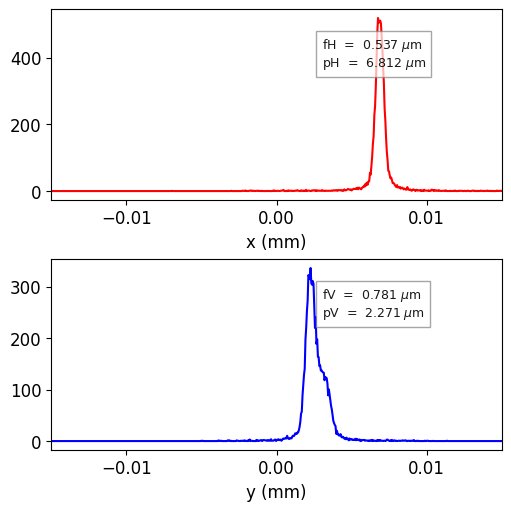

In [138]:
t = study.trials[0]
print("Trial number", t.number)
print(f"Trial values: peak_distance {t.values[1]:4.3e} fwhm {t.values[0]:4.3e}")
print("Trial dw:")

dwd = dict(t.user_attrs["dw"]._DictionaryWrapper__dictionary)
print(dwd)

print("Params:")
print(t.params)
hist = hists[t.number]
xdata = hist.data_2D.sum(axis=1)
ydata = hist.data_2D.sum(axis=0)

fig, axs = plt.subplots(2, 1, figsize=[5, 5], constrained_layout=True)
axs[0].plot(hist.hh, xdata, color='red')
axs[0].set_xlim(-0.015, 0.015)
axs[0].set_xlabel(r'x (mm)')
axs[0].locator_params(nbins=4)


axs[1].plot(hist.vv[::-1], ydata, color='blue')
axs[1].set_xlim(-0.015, 0.015)
axs[1].set_xlabel(r'y (mm)')

axs[1].locator_params(nbins=4)



text1 = (
    rf"{'fH':<3} = {dwd['h_fwhm'] * 1000: 4.3f} $\mu$m" + "\n"
    rf"{'pH':<3} = {dwd['h_peak']* 1000: 4.3f} $\mu$m"
)
axs[0].text(
    0.6,
    0.7,
    text1,
    color="black",
    alpha=0.9,
    fontsize=9,
    bbox=dict(facecolor="white", edgecolor="gray", alpha=0.7),
    transform=axs[0].transAxes,
)

text2 = (
    rf"{'fV':<3} = {dwd['v_fwhm']* 1000: 4.3f} $\mu$m" + "\n"
    rf"{'pV':<3} = {dwd['v_peak']* 1000: 4.3f} $\mu$m"
    
)

axs[1].text(
    0.6,
    0.7,
    text2,
    color="black",
    alpha=0.9,
    fontsize=9,
    bbox=dict(facecolor="white", edgecolor="gray", alpha=0.7),
    transform=axs[1].transAxes,
)
#plt.savefig(f"{out_dir}/initial.svg", bbox_inches="tight", dpi=600)
plt.show()

In [139]:
nash_trial, nash_idx, n_doms = analysis.select_nash_equil_trial_from_pareto_front(study)

In [140]:
n_doms

[22, 128, 109, 124]

Trial number 58
Trial values: peak_distance 7.720e-05 fwhm 1.552e-03
Trial dw:
{'h_sigma': 0.0009709058809206342, 'h_fwhm': 0.0006347656250000541, 'h_centroid': 0.00039463264349540216, 'h_peak': 7.324218750000104e-05, 'v_sigma': 0.0009055863296857202, 'v_fwhm': 0.0014160156250001207, 'v_centroid': -0.0004592861645410841, 'v_peak': -2.4414062500000347e-05, 'integral_intensity': 8338.830158279761, 'peak_intensity': 18.75989680527268, 'gaussian_fit': {}}
Params:
{'hb_trans': 7.200000000000003, 'vb_trans': 2.6000000000000014, 'hb_pitch': 0.0010000000000000009, 'vb_pitch': -0.0024999999999999988, 'hb_1': 24.643300000000004, 'hb_2': 4.147400000000005, 'vb_1': -13.320599999999999, 'vb_2': 3.910499999999999}


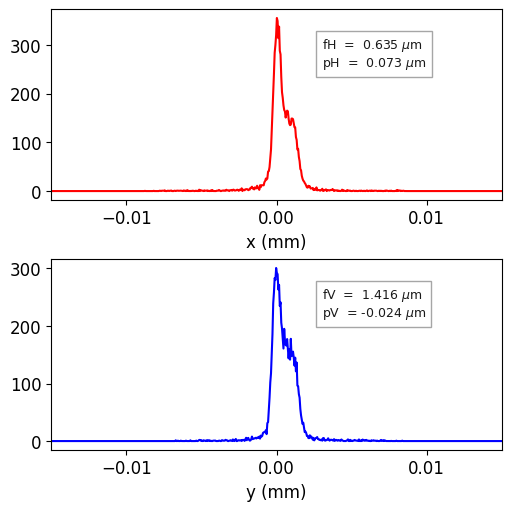

Trial number 66
Trial values: peak_distance 5.270e-04 fwhm 7.627e-04
Trial dw:
{'h_sigma': 0.0009127860515637075, 'h_fwhm': 0.00058593750000005, 'h_centroid': -0.0005350942405167294, 'h_peak': -0.0005126953125000003, 'v_sigma': 0.0007839073181392163, 'v_fwhm': 0.0004882812500000416, 'v_centroid': 0.00024264249794625248, 'v_peak': -0.0001220703125, 'integral_intensity': 8336.393507192905, 'peak_intensity': 40.276083560123645, 'gaussian_fit': {}}
Params:
{'hb_trans': 4.600000000000001, 'vb_trans': 2.900000000000002, 'hb_pitch': -0.01125, 'vb_pitch': -0.0024999999999999988, 'hb_1': 0.8754000000000026, 'hb_2': 12.0552, 'vb_1': -16.4545, 'vb_2': 20.1575}


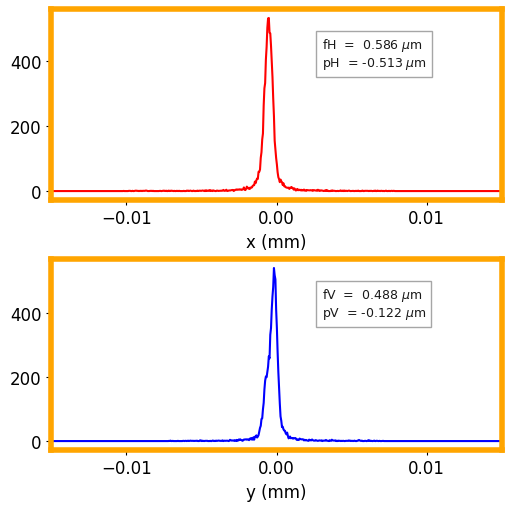

Trial number 71
Trial values: peak_distance 4.271e-04 fwhm 8.694e-04
Trial dw:
{'h_sigma': 0.0009425207175290862, 'h_fwhm': 0.0006835937500000583, 'h_centroid': -0.0002818921841656868, 'h_peak': -0.0003662109375, 'v_sigma': 0.0013286694480392556, 'v_fwhm': 0.0005371093750000458, 'v_centroid': -0.0005574131139709484, 'v_peak': -0.00021972656249999965, 'integral_intensity': 8335.898549983029, 'peak_intensity': 26.87661093599101, 'gaussian_fit': {}}
Params:
{'hb_trans': 4.200000000000003, 'vb_trans': 1.6000000000000014, 'hb_pitch': -0.01125, 'vb_pitch': 0.0010000000000000009, 'hb_1': -8.5624, 'hb_2': 14.1177, 'vb_1': -4.4163, 'vb_2': -22.1331}


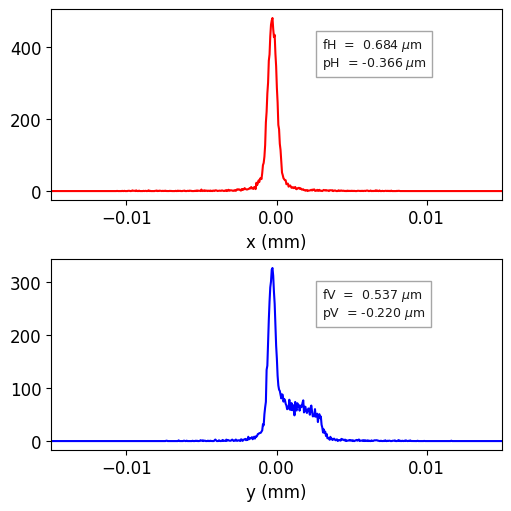

Trial number 112
Trial values: peak_distance 1.050e-03 fwhm 7.259e-04
Trial dw:
{'h_sigma': 0.001065223998136212, 'h_fwhm': 0.0004882812500000416, 'h_centroid': 0.00023594998647885138, 'h_peak': 0.00031738281250000104, 'v_sigma': 0.0008780380147968614, 'v_fwhm': 0.0005371093750000458, 'v_centroid': 0.0005936667786258856, 'v_peak': -0.0010009765625000003, 'integral_intensity': 8342.253911184185, 'peak_intensity': 36.21499168384306, 'gaussian_fit': {}}
Params:
{'hb_trans': 11.3, 'vb_trans': 3.900000000000002, 'hb_pitch': 0.0185, 'vb_pitch': -0.0024999999999999988, 'hb_1': 3.3813999999999993, 'hb_2': 7.677, 'vb_1': 11.714300000000001, 'vb_2': 16.181400000000004}


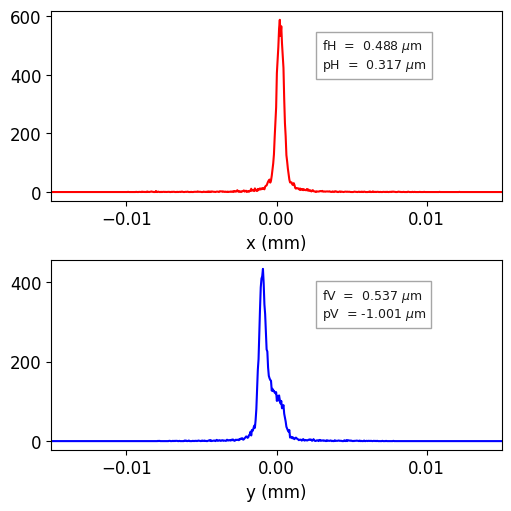

In [141]:
best_hists = []
for t in study.best_trials:
    print("Trial number", t.number)
    print(f"Trial values: peak_distance {t.values[1]:4.3e} fwhm {t.values[0]:4.3e}")
    print("Trial dw:")

    dwd = dict(t.user_attrs["dw"]._DictionaryWrapper__dictionary)
    print(dwd)
    
    print("Params:")
    print(t.params)
    
    
    hist = hists[t.number]
    xdata = hist.data_2D.sum(axis=1)
    ydata = hist.data_2D.sum(axis=0)
    
    fig, axs = plt.subplots(2, 1, figsize=[5, 5], constrained_layout=True)
    axs[0].plot(hist.hh, xdata, color='red')
    axs[0].set_xlim(-0.015, 0.015)
    axs[0].set_xlabel(r'x (mm)')
    axs[0].locator_params(nbins=4)
    
    
    axs[1].plot(hist.vv[::-1], ydata, color='blue')
    axs[1].set_xlim(-0.015, 0.015)
    axs[1].set_xlabel(r'y (mm)')
    
    axs[1].locator_params(nbins=4)
    
    
    
    text1 = (
        rf"{'fH':<3} = {dwd['h_fwhm'] * 1000: 4.3f} $\mu$m" + "\n"
        rf"{'pH':<3} = {dwd['h_peak']* 1000: 4.3f} $\mu$m"
    )
    axs[0].text(
        0.6,
        0.7,
        text1,
        color="black",
        alpha=0.9,
        fontsize=9,
        bbox=dict(facecolor="white", edgecolor="gray", alpha=0.7),
        transform=axs[0].transAxes,
    )
    
    text2 = (
        rf"{'fV':<3} = {dwd['v_fwhm']* 1000: 4.3f} $\mu$m" + "\n"
        rf"{'pV':<3} = {dwd['v_peak']* 1000: 4.3f} $\mu$m"
        
    )
    
    axs[1].text(
        0.6,
        0.7,
        text2,
        color="black",
        alpha=0.9,
        fontsize=9,
        bbox=dict(facecolor="white", edgecolor="gray", alpha=0.7),
        transform=axs[1].transAxes,
    )
    #plt.savefig(f"{out_dir}/pareto_{t.number}.svg", bbox_inches="tight", dpi=600)

    #plt.savefig(f"{out_dir}/pareto_{t.number}.png", bbox_inches="tight", dpi=600)
    if t.number == nash_trial.number:
        for axis in ["top", "bottom", "left", "right"]:
            axs[0].spines[axis].set_linewidth(4)
            axs[0].spines[axis].set_color("orange")
            axs[1].spines[axis].set_linewidth(4)
            axs[1].spines[axis].set_color("orange")
    plt.show()

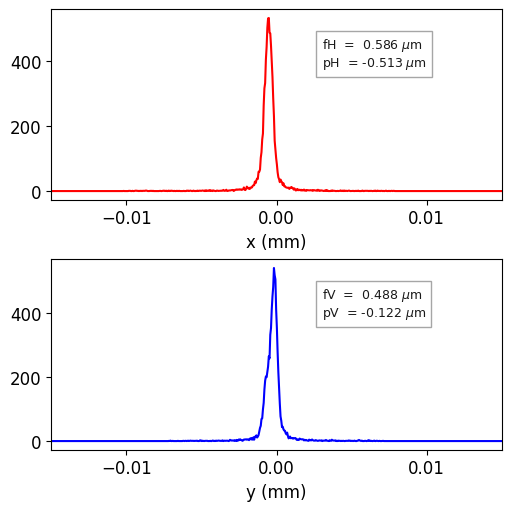

In [142]:
tnum = nash_trial.number
dwd = dict(**study.trials[tnum].user_attrs["dw"]._DictionaryWrapper__dictionary)

hist = hists[tnum]

xdata = hist.data_2D.sum(axis=1)
ydata = hist.data_2D.sum(axis=0)

fig, axs = plt.subplots(2, 1, figsize=[5, 5], constrained_layout=True)
axs[0].plot(hist.hh, xdata, color='red')
axs[0].set_xlim(-0.015, 0.015)
axs[0].set_xlabel(r'x (mm)')
axs[0].locator_params(nbins=4)


axs[1].plot(hist.vv[::-1], ydata, color='blue')
axs[1].set_xlim(-0.015, 0.015)
axs[1].set_xlabel(r'y (mm)')

axs[1].locator_params(nbins=4)



text1 = (
    rf"{'fH':<3} = {dwd['h_fwhm'] * 1000: 4.3f} $\mu$m" + "\n"
    rf"{'pH':<3} = {dwd['h_peak']* 1000: 4.3f} $\mu$m"
)
axs[0].text(
    0.6,
    0.7,
    text1,
    color="black",
    alpha=0.9,
    fontsize=9,
    bbox=dict(facecolor="white", edgecolor="gray", alpha=0.7),
    transform=axs[0].transAxes,
)

text2 = (
    rf"{'fV':<3} = {dwd['v_fwhm']* 1000: 4.3f} $\mu$m" + "\n"
    rf"{'pV':<3} = {dwd['v_peak']* 1000: 4.3f} $\mu$m"
    
)

axs[1].text(
    0.6,
    0.7,
    text2,
    color="black",
    alpha=0.9,
    fontsize=9,
    bbox=dict(facecolor="white", edgecolor="gray", alpha=0.7),
    transform=axs[1].transAxes,
)
#plt.savefig(f"{out_dir}/pareto_hh.svg", bbox_inches="tight", dpi=600)
#plt.savefig(f"{out_dir}/pareto_hh.png", bbox_inches="tight", dpi=600)
plt.show()

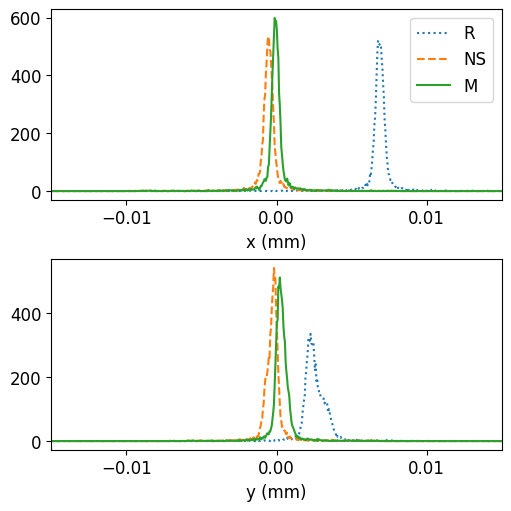

In [143]:
tnum = nash_trial.number
dwd = dict(**study.trials[tnum].user_attrs["dw"]._DictionaryWrapper__dictionary)

hist = hists[tnum]

xdata = hist.data_2D.sum(axis=1)
ydata = hist.data_2D.sum(axis=0)

hist2 = hists[0]
xdata2 = hist2.data_2D.sum(axis=1)
ydata2 = hist2.data_2D.sum(axis=0)

hist3 = ground_hist
xdata3 = hist3.data_2D.sum(axis=1)
ydata3 = hist3.data_2D.sum(axis=0)

fig, axs = plt.subplots(2, 1, figsize=[5, 5], constrained_layout=True)

axs[0].plot(hist2.hh, xdata2,  label='R', ls=':')
axs[0].plot(hist.hh, xdata,  label='NS', ls='--')
axs[0].plot(hist3.hh, xdata3, label='M', ls='-',)

axs[0].set_xlim(-0.015, 0.015)
axs[0].set_xlabel(r'x (mm)')
axs[0].locator_params(nbins=4)
axs[0].legend(loc='best')


axs[1].plot(hist2.vv[::-1], ydata2,  label='R', ls=':')
axs[1].plot(hist.vv[::-1], ydata,  label='NS', ls='--')
axs[1].plot(hist3.vv[::-1], ydata3,  label='M', ls='-')

axs[1].set_xlim(-0.015, 0.015)
axs[1].set_xlabel(r'y (mm)')

axs[1].locator_params(nbins=4)



plt.show()

In [144]:
c1 = [nash_trial.number]
c2 = [t.number for t in study.best_trials if t.number not in c1]
c3 = [n for n in range(len(hists)) if n not in c1 and n not in c2]

In [145]:
c2

[58, 71, 112]

In [146]:
def get_y_values(study, val_index):
    y = []
    for t in study.trials:
        if t.values is None:
            y.append(np.nan)
        else:
            y.append(t.values[val_index])
    return np.array(y)
    

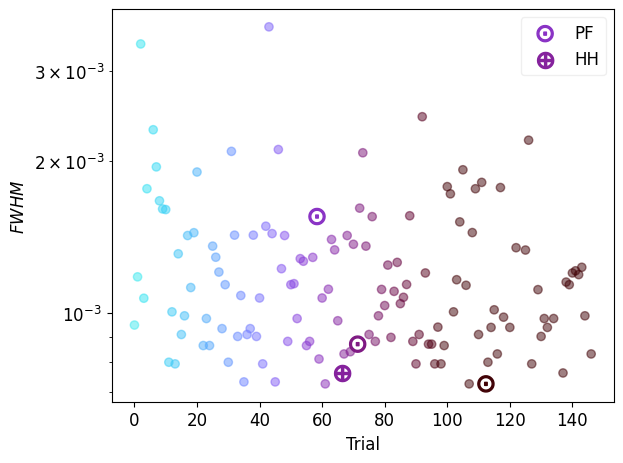

In [147]:
# Plotting the optimization histories
# optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: t.values[0], target_name="$f_3$")
# plt.scatter(study.trials.values


plt.figure()
x = np.array([t.number for t in study.trials])
y = get_y_values(study, 0)

plt.scatter(x[c3], y[c3], c=c3, cmap=cmm.gem_r, marker="o", alpha=0.5, norm=mpl.colors.Normalize(0, 100))
plt.scatter(x[c2], y[c2], c=c2, cmap=cmm.gem_r, marker=r"$\odot$", s=175, norm=mpl.colors.Normalize(0, 100), label="PF")
plt.scatter(
    x[c1], y[c1], c=c1, cmap=cmm.gem_r, marker=r"$\oplus$", s=175, norm=mpl.colors.Normalize(0, 100), label="HH"
)

plt.xlabel("Trial")
plt.ylabel("$FWHM$")
plt.yscale("log")
# for t in study.best_trials[:-1]:
#    plt.axvline(t.number, color='red', ls=':')
# plt.axvline(study.best_trials[-1].number, color='red', ls=':', label='PT')
# plt.axvline(nash_trial.number, color='orange', label='NS')
plt.legend(loc="best", framealpha=0.3)
plt.tight_layout()
plt.show()

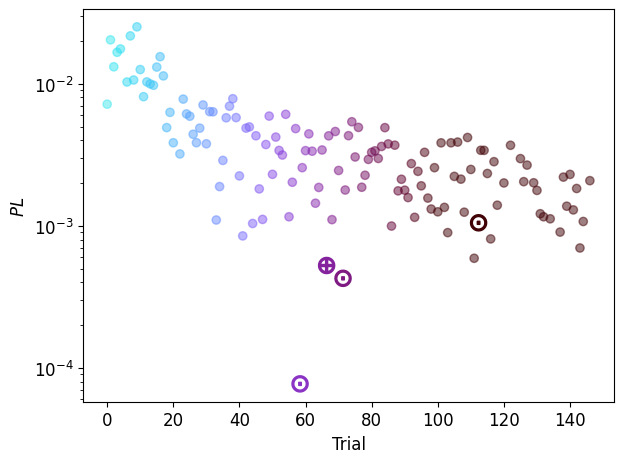

In [148]:
# Plotting the optimization histories
# optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: t.values[0], target_name="$f_3$")
# plt.scatter(study.trials.values
plt.figure()
x = np.array([t.number for t in study.trials])
y = get_y_values(study, 1)

plt.scatter(x[c3], y[c3], c=c3, cmap=cmm.gem_r, marker="o", alpha=0.5, norm=mpl.colors.Normalize(0, 100))
plt.scatter(x[c2], y[c2], c=c2, cmap=cmm.gem_r, marker=r"$\odot$", s=175, norm=mpl.colors.Normalize(0, 100), label="PF")
plt.scatter(
    x[c1], y[c1], c=c1, cmap=cmm.gem_r, marker=r"$\oplus$", s=175, norm=mpl.colors.Normalize(0, 100), label="NS"
)

plt.xlabel("Trial")
plt.ylabel("$PL$")
plt.yscale("log")
# for t in study.best_trials[:-1]:
#    plt.axvline(t.number, color='red', ls=':')
# plt.axvline(study.best_trials[-1].number, color='red', ls=':', label='PT')
# plt.axvline(nash_trial.number, color='orange', label='NS')
plt.tight_layout()
plt.show()

In [149]:
ground

{'FWHM': 0.0007627196949128243, 'PL': 0.00027836314089334333}

In [150]:
out_dir

PosixPath('/Users/skandel/Library/CloudStorage/Box-Box/autofocus_paper/figures/34idc_sim_peak_fwhm_nlpi/noise_free_onestep')

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_71135/3019828700.py:29: MatplotlibDeprecationWarning: The execute_constrained_layout function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use figure.get_layout_engine().execute() instead.
  fig.execute_constrained_layout()


4.4606133688932275 4.352882222222222


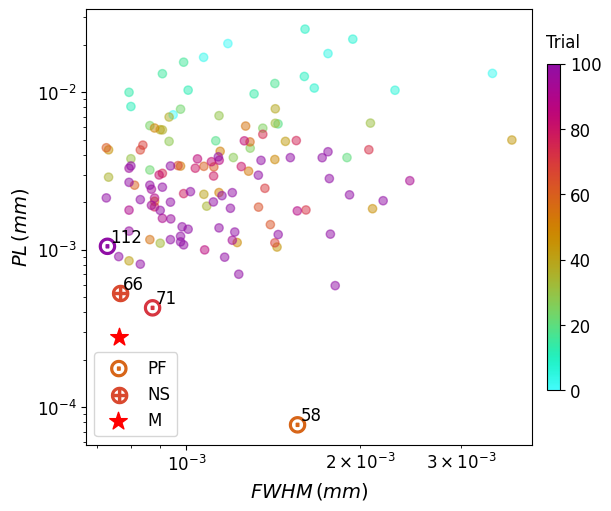

In [151]:
x = get_y_values(study, 0)
y = get_y_values(study, 1)

fig = plt.figure(figsize=[6, 5], constrained_layout=True)
plt.scatter(x[c3], y[c3], c=c3, cmap=cmm.tropical_r, marker="o", alpha=0.5, norm=mpl.colors.Normalize(0, 100))
plt.scatter(
    x[c2], y[c2], c=c2, cmap=cmm.tropical_r, marker=r"$\odot$", s=175, norm=mpl.colors.Normalize(0, 100), label="PF"
)
plt.scatter(
    x[c1], y[c1], c=c1, cmap=cmm.tropical_r, marker=r"$\oplus$", s=175, norm=mpl.colors.Normalize(0, 100), label="NS"
)

for t in study.best_trials:
    plt.annotate(t.number, xy=(x[t.number], y[t.number]), xytext=(3, 3), textcoords="offset points")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("$FWHM\,(mm)$", fontsize=14)
plt.ylabel("$PL\,(mm)$", fontsize=14)
cbar = plt.colorbar(pad=0.03, aspect=25, shrink=0.75, location="right")
# cbar.ax.set_ylabel('Trial')
cbar.ax.text(-0.1, 105.0, "Trial")
# cbar.ax.set_xlabel('Trial')#, fontsize=14)

plt.scatter(ground["FWHM"], ground["PL"], color="red", marker="*", s=175, label="M")
plt.legend(loc="best")
r = fig.canvas.get_renderer()
ax = plt.gca()

fig.execute_constrained_layout()
print(ax.bbox.width / fig.dpi, ax.bbox.height / fig.dpi)
#plt.savefig(f"{out_dir}/pareto_fwhm_pl.svg", bbox_inches="tight", dpi=600)

#plt.savefig(f"{out_dir}/pareto_fwhm_pl.png", bbox_inches="tight", dpi=600)
plt.show()

### Combining the figures into one

In [152]:
nash_idx, nash_trial.number

(1, 66)

In [153]:
ground

{'FWHM': 0.0007627196949128243, 'PL': 0.00027836314089334333}

In [154]:
props = apu.AnalyzedProps(study, nash_trial, max_count=maxcount, min_count=0, xylim=0.012, distance_units='um', float_format='4.2f', hist_nlpi_text=False)

In [155]:
markers = [".", 'o', 'D',  's', 'P', 'X', '<','>','^','v', '1', '2']
linestyle_tuple = [
     ('dotted',                (0, (1, 1))),
     ('densely dotted',        (0, (1, 1))),
     ('dashed',                (0, (5, 5))),
     ('densely dashed',        (0, (5, 1))),

     ('densely dashdotted',    (0, (3, 1, 1, 1))),

     ('dashdotdotted',         (0, (3, 5, 1, 5, 1, 5))),
     ('loosely dashdotdotted', (0, (3, 10, 1, 10, 1, 10))),
     ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)))]
lst = [t[1] for t in linestyle_tuple]

#prop_cycler = cycler(marker=markers) + cycler(ls=lst) #+ cycler(color=colors)
prop_cycler = cycler(ls=lst)



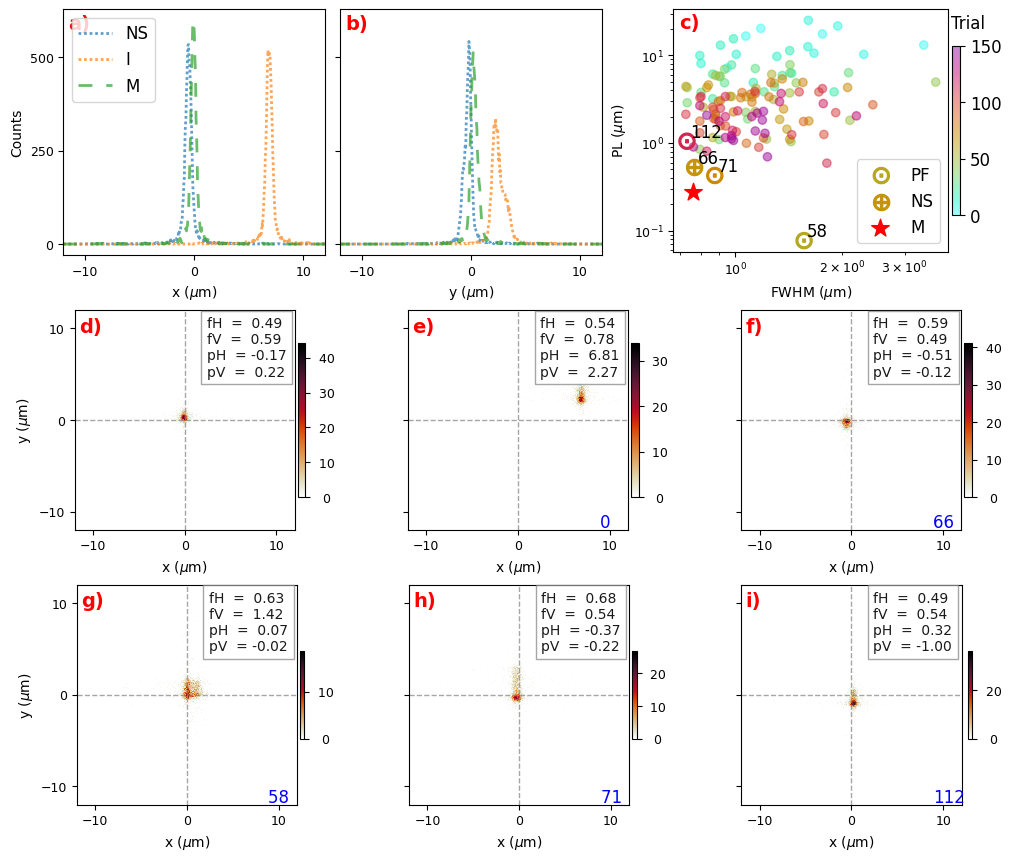

In [164]:
fig = plt.figure(figsize=[10, 8.5], layout="constrained")
#gs0 = gridspec.GridSpec(3, 1, figure=fig, height_ratios=[0.44, 0.21, 0.35])
gs0 = gridspec.GridSpec(3, 1, figure=fig, height_ratios=[0.35, 0.32,0.32])

# top row
gss0 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs0[0], width_ratios=[0.6,0.4])
gss00 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gss0[0])

axs0 = gss00.subplots(sharey=True)

pc = prop_cycler()
sublabel = apu.plot_1d_lines(props, axs0[0], hists[nash_trial.number], hist_ground=ground_hist, hist_init=hists[0], label='NS', 
                             cyc=pc, sublabel='a', labelfontsize=10, ticklabelsize=9, axis=1)

#for ix, t in enumerate(study.best_trials):
#    if t.number == nash_trial.number: continue
#    apu.plot_1d_lines(axs0[0], hists[t.number], label=f'PF{t.number}', cyc=pc, labelfontsize=10)

#axs0[0].set_xlim(-0.009, 0.009)
axs0[0].locator_params(nbins=3)
axs0[0].legend(loc='best')
axs0[0].set_ylabel('Counts', fontsize=10)


pc = prop_cycler()
sublabel = apu.plot_1d_lines(props, axs0[1], hists[nash_trial.number], hist_ground=ground_hist, hist_init=hists[0], label='NS', cyc=pc, axis=0,
                            sublabel=sublabel, labelfontsize=10)

#for ix, t in enumerate(study.best_trials):
#    if t.number == nash_trial.number: continue
#    apu.plot_1d_lines(axs0[1], hists[t.number], label=f'PF{t.number}', cyc=pc, axis=1, labelfontsize=10)

#axs0[1].set_xlim(-0.009, 0.009)
axs0[1].locator_params(nbins=3)


gss01 = gridspec.GridSpecFromSubplotSpec(1,1,subplot_spec=gss0[1])
axs01 = gss01.subplots()
cscatter, sublabel = apu.plot_pareto_2d(
    props, axs01, "FWHM", "PL", sublabel=sublabel, ground=ground, annotate=True, legend=True, fontsize=10, ticklabelsize=9
)
#_, sublabel = apu.plot_pareto_2d(props, axs2[1], "FWHM", "NLPI", sublabel=sublabel, ground=ground)
#_, sublabel = apu.plot_pareto_2d(props, axs2[2], "PL", "NLPI", sublabel=sublabel, ground=ground)

cbar = plt.colorbar(cscatter, ax=axs01, pad=0.01, shrink=0.7, location="right")
cbar.ax.text(-0.1, 1.1, "Trial", transform=cbar.ax.transAxes)



# middle row
gss1 = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs0[1])
axs1 = gss1.subplots(sharex=True, sharey=True)

cmesh, sublabel = apu.plot_hist_2d(props, axs1[0], ground_hist, ylabel=True, ticklabelsize=9, sublabel=sublabel, labelfontsize=10)
apu.add_text_to_hist(props, axs1[0], ground_dw, fontsize=10)

cmesh0, sublabel = apu.plot_hist_2d(props, axs1[1], hists[0], study_num=0, sublabel=sublabel, ticklabelsize=9, labelfontsize=10)
apu.add_text_to_hist(props, axs1[1], study.trials[0].user_attrs["dw"], fontsize=10)

cmesh1, sublabel = apu.plot_hist_2d(props, axs1[2], hists[nash_trial.number], study_num=nash_trial.number, sublabel=sublabel, 
                                    ticklabelsize=9, labelfontsize=10)
apu.add_text_to_hist(props, axs1[2], study.trials[nash_trial.number].user_attrs["dw"], fontsize=10)
# _, sublabel = apu.

for ix, cmesh in enumerate([cmesh, cmesh0, cmesh1]):
    cbar = fig.colorbar(cmesh, ax=axs1[ix], pad=0.01, shrink=0.7, format='%3.0f')
    cbar.ax.tick_params(labelsize=9)
    axs1[ix].locator_params(nbins=4)


# bottom row
gss2 = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs0[2])
axs2 = gss2.subplots(sharey=True)
axs2 = axs2.flatten()


_trials = [t for t in study.best_trials if t.number != nash_trial.number]

for ax in axs2:
    ax.axis('off')

for ix, t in enumerate(_trials):
    axs2[ix].axis('on')
    ylabel = True if ix == 0 else False
    cmesh, sublabel = apu.plot_hist_2d(props, axs2[ix], hists[t.number], ylabel=ylabel, ticklabelsize=9, 
                                       sublabel=sublabel, study_num=t.number, labelfontsize=10)
    apu.add_text_to_hist(props, axs2[ix], t.user_attrs["dw"], fontsize=10)

    cbar = fig.colorbar(cmesh, ax=axs2[ix], pad=0.01, shrink=0.4, format='%3.0f')
    cbar.ax.tick_params(labelsize=9)
    axs2[ix].locator_params(nbins=4)

plt.savefig(f"{out_dir}/fig_combined.pdf", bbox_inches="tight", dpi=600)
plt.savefig(f"{out_dir}/fig_combined.png", bbox_inches="tight", dpi=600)
plt.show()